In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy
import cv2
import random
import os
import sys
sys.path.append("../../")
import helpers
import gfx
import numba

# Material matching
In the previous weeks you learned how a depth map can be reconstructed from a set of images. There are also multi-view stereo algorithms that output a 3D surface instead of a point cloud (collection of 3D points). In those cases it is often desirable to capture not only the shape of an object but also its appearance.

Capturing the surface appearance of on object might seem simple: just get the pixel values of the images used for reconstruction. This does not work however when viewing the virtual object from different angles. Furthermore, we would implicitely capture the scenes lighting with no way to change it. Instead we want to capture the way the surface reacts to light.

To capture the surface appearance we could take many pictures (from different angles and with different light directions) and store the reflectance in a look-up table. This would however not be a very efficient process as it requires a lot of time and compute resources. A more effective way of capturing the reflectance is to fit it to a mathematical model.

Visualizing objects with different materials has been an active research topic in computer graphics since its inception. We use mathematical models (Bidirectional Reflection Distribution Function or BRDF for short) to model how light reflects of a surface. By changing the parameters of these models many different materials can be represented. The goal of material matching is to match a mathematical model to real world appearance by finding these parameters.

## Renderer
Usually material matching would come at the end of the multi-view stereo pipeline. But for educational purposes we have chosen to generate input data directly using a small renderer instead. A renderer is a piece of software that generates images given a description of a virtual scene and camera. The `render(camera, sphere, light, brdf, width, height)` function will generate an image as seen from the camera of the given sphere with the given light and surface reflection function. This way the input does not contain any measurement noise and it becomes easy to verify whether a solution is correct or not.

The render function will return three distinct image. The first image contains the familiar Red, Green, and Blue colors. The second image stores for each pixel a 3D position in space: the location of the surface of the sphere at that pixel. Finally, the third image stores for each pixel a normal vector: the orientation of the surface. An example of the three images are shown below.

Wall time: 185 ms
Wall time: 213 ms
Wall time: 246 ms


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
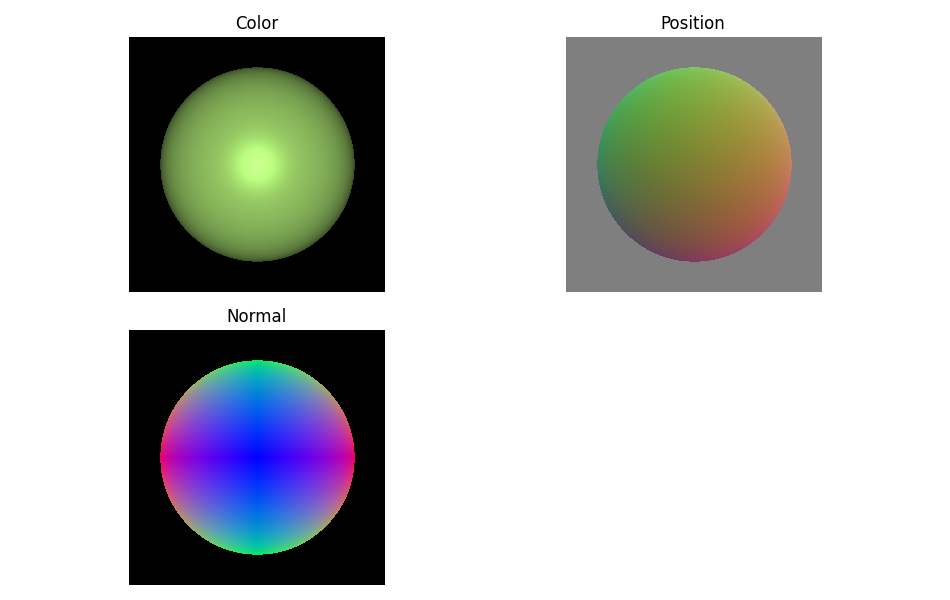

In [7]:
camera = gfx.Camera(gfx.Vec3(0, 0, -5), gfx.Vec3(0, 0, 0), gfx.Vec3(0, 1, 0), 45.0, 1.0)
sphere = gfx.Sphere(gfx.Vec3(0, 0, 0), 1.5)
light = gfx.DirectionalLight(gfx.Vec3(0, 0, 1), gfx.Vec3(1, 1, 1))
brdf = gfx.PhongBRDF(gfx.Vec3(0.6, 0.8, 0.4), gfx.Vec3(0.2, 0.3, 0.15), 9)

# Because of JIT compilation the first run is slow but every invocation afterwards is fast.
%time colors, positions, normals = gfx.render(camera, sphere, light, brdf, 256, 256)
%time colors, positions, normals = gfx.render(camera, sphere, light, brdf, 256, 256)
%time colors, positions, normals = gfx.render(camera, sphere, light, brdf, 256, 256)
helpers.show_images({
    "Color": np.clip(colors, 0, 1),
    "Position": (positions+2.5)/5,
    "Normal": np.abs(normals)
}, nrows=2, ncols=2)

### Python / Performance
Because of performance reasons the renderer is again implemented using Numba to (JIT) compile the Python code. We provide some helper functions in the `gfx` file to create/operate with 3D vectors (represented as Numpy arrays). The `gfx` file also contains all classes necessary to describe a scene (`Sphere`, `Camera`, `PointLight`, `PhongBRDF`).

**Do following code is not supposed to run, it's only a list of the provided functions**

In [4]:
def this_does_not_run():
    a = gfx.Vec3(0, 1, 2) # Equivalent to: np.array([0, 1, 2], np.float32)

    sphere = gfx.Sphere(center, radius) # Create a sphere at center with radius

    camera = gfx.Camera(...) # Create camera (always done for you)
    pos = camera.position() # Returns camera position as np.array

    light = gfx.PointLight(position, intensity) # Create a infinitely small point of light at position with a given intensity (color)
    # For any given point in the scene, compute the direction of the incoming light (normalized vector from point3D towards light)
    #  and the intensity (color) of the light at that point
    direction, intensity = light.light_at_point(point3D)

    # Compute reflection ray for given normal and light direction (pointing away from the normal)
    R = gfx.reflect(light_vec, normal)

## Phong Material Model
One of the most well known light reflectance models is the Phong reflectance function. It separates the light interaction into two parts: diffuse and specular reflections. Diffuse reflections scatter the incoming light in all directions resulting in a matte appearance. Specular reflections cause shiny highlights (like a mirror). The Phong model is written as:

$$
C = k_d I (L \cdot N) + k_s I (E \cdot R)^t
$$

Here $C$ is the color of the pixel, $I$ is the color of the incoming light, $L$ is the incoming light direction (pointing towards the light source), $N$ is the surface normal, $E$ is the eye direction and $R$ is reflected light vector ($R=2(L \cdot N)N - L$, provided by `gfx.reflect(N, L)`). *Both dot products should be clamped to prevent negative values* (normal is pointing away from $L$ or $R$). The parameters are the diffuse reflection color $k_d$, the specular reflectance color $k_s$ and the shininess $t$ which controls the size and brightness of the specular highlight.

### Exercise 3 (2 points)
Your job is to find a material which matches the appearance of the sphere in the given image. Find the parameters $k_s$ and $k_d$ of the Phong model that were used to render the images by formulating the problem as a linear system and finding the least squares solution. Each pixel that shows the sphere (= not background pixels) should add contraints to the linear system. Assume for this exercise that the given $t$ is correct.

The colors, positions and normals are all given as images. Background pixels an empty normal vector (`N = [0, 0, 0]`). The light is provided so that you can compute the incoming light direction/color at any point. Use `light_direction, light_color = light.light_at_point(point)`. Recall that the view vector of the Phong model should be normalized (length 1) and point from the surface towards the camera.

Construct a linear system to find $k_d$ and $k_s$ and solve it using `np.linalg.lstsq(A, b)[0]`.

Your estimated parameters: kd=[0.60000001 0.2        0.3       ], ks=[0.29999997 0.49999992 0.19999997]
Actual parameters: kd=[0.6 0.2 0.3], ks=[0.3 0.5 0.2]

SSD per pixel: 1.216474837528736e-16


C:\Users\GONEM_~1\AppData\Local\Temp/ipykernel_5768/1182574406.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  K = np.linalg.lstsq(A, b)[0]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
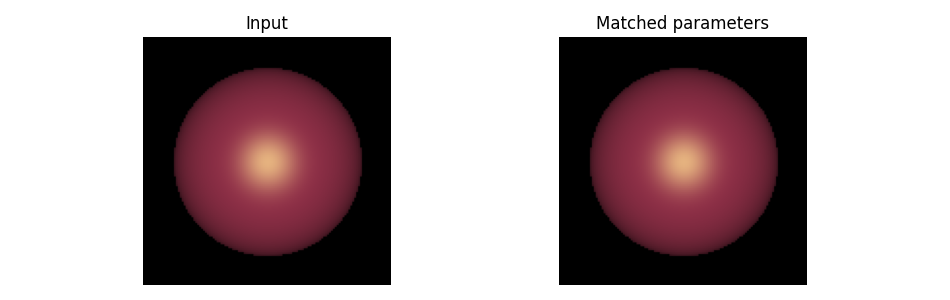

In [178]:
def solve_phong_kd_ks(colors, positions, normals, t, camera_pos, light):
    assert colors.shape == positions.shape == normals.shape

    A = np.zeros((0, 6))
    b = np.zeros(0)
    for color_row, position_row, normal_row in zip(colors, positions, normals):
        for color, position, normal in zip(color_row, position_row, normal_row):
            if not normal.any():
                continue
            light_direction, light_color = light.light_at_point(position)
            assert np.linalg.norm(light_direction) == 1
            normal = normal / np.linalg.norm(normal)

            assert np.dot(normal, light_direction) >= 0
            dotnL = max(np.dot(normal, light_direction), 0)

            diff = light_color * dotnL
            
            R = gfx.reflect(normal, light_direction)
            R = R / np.linalg.norm(R)
            E = camera_pos - position
            E = E / np.linalg.norm(E)
            dotER = max(np.dot(E, R), 0)
            spec = light_color * dotER ** t
            A_rows = np.array([
                [diff[0], spec[0], 0, 0, 0, 0],
                [0, 0, diff[1], spec[1], 0, 0],
                [0, 0, 0, 0, diff[2], spec[2]]
            ])
            A = np.vstack((A, A_rows))
            b = np.concatenate((b, color))
    K = np.linalg.lstsq(A, b)[0]
    kd = K[[0,2,4]]
    ks = K[[1,3,5]]
    return kd, ks

width = height = 128
camera = gfx.Camera(gfx.Vec3(0, 0, -5), gfx.Vec3(0, 0, 0), gfx.Vec3(0, 1, 0), 45.0, 1.0)
sphere = gfx.Sphere(gfx.Vec3(0, 0, 0), 1.5)
light = gfx.DirectionalLight(gfx.Vec3(0, 0, 1), gfx.Vec3(1, 1, 1))

kd = gfx.Vec3(0.6, 0.2, 0.3)
ks = gfx.Vec3(0.3, 0.5, 0.2)
t = 7
brdf = gfx.PhongBRDF(kd, ks, t)

colors, positions, normals = gfx.render(camera, sphere, light, brdf, width, height)
kd_estimate, ks_estimate = solve_phong_kd_ks(colors, positions, normals, t, camera.position, light)

print(f"Your estimated parameters: kd={kd_estimate}, ks={ks_estimate}")
print(f"Actual parameters: kd={kd}, ks={ks}\n")
matched_image, _, _ = gfx.render(camera, sphere, light, gfx.PhongBRDF(kd_estimate.astype(np.float32), ks_estimate.astype(np.float32), t), width, height)

print(f"SSD per pixel: {helpers.SSD_per_pixel(colors, matched_image)}")
helpers.show_images({ "Input": colors, "Matched parameters": matched_image }, nrows=1, ncols=2)

### Tests of exercise 3
The parameters that your solution picked should result in an image that is extremely close to the input image.

## Computing shininess
Finding $k_d$ and $k_s$ when $t$ is known is simple since the reflectance function (and thus the final color output) is linear with respect to $k_d$ and $k_s$. The shininess term $t$ does not have a linear relation to the output. This problem is very common in more complex reflection models which are never just a linear blend of parameters.

$$
k_d I (L \cdot N) + k_s I (E \cdot R)^t
$$

Assume that we know $k_d$ and $k_s$, making $t$ the only unknown variable. We can reformulate the Phong formula (above) such that it states $t=\text{...}$ . With this we can estimate $t$ for every pixel & color channel. Take the average over all (non background) pixels to get an accurate estimate of the shininess value $t$ of the sphere.

### Exercise 4 (2 points)
Implement a function that computes $t$ given $k_d$ and $k_s$ using the method described above.

C:\Users\GONEM_~1\AppData\Local\Temp/ipykernel_5768/2140401287.py:26: RuntimeWarning: divide by zero encountered in log
  t_new = np.log((color-diff) / (ks * light_color)) / np.log(np.dot(E, R))
C:\Users\GONEM_~1\AppData\Local\Temp/ipykernel_5768/2140401287.py:26: RuntimeWarning: invalid value encountered in log
  t_new = np.log((color-diff) / (ks * light_color)) / np.log(np.dot(E, R))
C:\Users\GONEM_~1\AppData\Local\Temp/ipykernel_5768/2140401287.py:26: RuntimeWarning: divide by zero encountered in true_divide
  t_new = np.log((color-diff) / (ks * light_color)) / np.log(np.dot(E, R))
C:\Users\GONEM_~1\AppData\Local\Temp/ipykernel_5768/2140401287.py:26: RuntimeWarning: invalid value encountered in true_divide
  t_new = np.log((color-diff) / (ks * light_color)) / np.log(np.dot(E, R))


Estimated parameters: t=3.9989525221963462
t error: 0.0010474778036537735


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
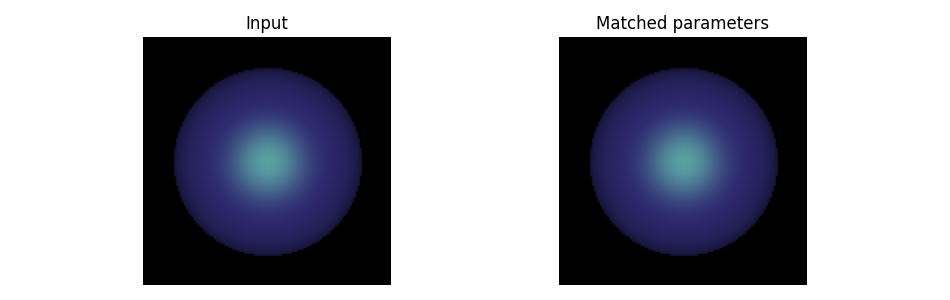

In [187]:
def solve_phong_t(colors, positions, normals, camera_pos, light, kd, ks):
    t = np.zeros(0)
    for color_row, position_row, normal_row in zip(colors, positions, normals):
        for color, position, normal in zip(color_row, position_row, normal_row):
            if not normal.any():
                continue
            light_direction, light_color = light.light_at_point(position)
            assert np.linalg.norm(light_direction) == 1
            normal = normal / np.linalg.norm(normal)

            assert np.dot(normal, light_direction) >= 0

            dotnL = max(np.dot(normal, light_direction), 0)

            diff = kd * light_color * dotnL
            
            
            R = gfx.reflect(normal, light_direction)
            R = R / np.linalg.norm(R)
            E = camera_pos - position
            E = E / np.linalg.norm(E)

            if np.dot(E, R) <= 0:
                continue

            t_new = np.log((color-diff) / (ks * light_color)) / np.log(np.dot(E, R))
            t = np.concatenate((t, t_new[t_new != np.inf]))
            
    t = t[~np.isnan(t)]
    return np.mean(t)


width = height = 128
camera = gfx.Camera(gfx.Vec3(0, 0, -5), gfx.Vec3(0, 0, 0),gfx. Vec3(0, 1, 0), 45.0, 1.0)
sphere = gfx.Sphere(gfx.Vec3(0, 0, 0), 1.5)
light = gfx.DirectionalLight(gfx.Vec3(0, 0, 1), gfx.Vec3(0.5, 0.9, 0.7))

kd = gfx.Vec3(0.4, 0.2, 0.7)
ks = gfx.Vec3(0.3, 0.5, 0.2)
t = 4
brdf = gfx.PhongBRDF(kd, ks, t)

colors, positions, normals = gfx.render(camera, sphere, light, brdf, width, height)
t_estimate = solve_phong_t(colors, positions, normals, camera.position, light, kd, ks)

print(f"Estimated parameters: t={t_estimate}")
print(f"t error: {np.abs(t - t_estimate)}")

matched_image, _, _ = gfx.render(camera, sphere, light, gfx.PhongBRDF(kd, ks, t_estimate), width, height)
helpers.show_images({
    "Input": colors,
    "Matched parameters": matched_image
}, nrows=1, ncols=2)

### Tests of exercise 4
Your method should be able to detect the $t$ value with high accuracy ($<0.001$)

### Exercise 5 (3 points)
We now have two functions: one to compute $k_d$ & $k_s$, and one to compute $t$. In practical applications we usually don't know any of these three values. We therefor need to combine the two functions above into a single function which finds values values for $k_d$, $k_s$ and $t$. A simple yet effective approach is to start with an initial guess and then alternating between solving for $k_d$/$k_s$, and $t$.

Initialize the unknowns ($k_d$, $k_s$ and $t$) to sensible random values. Alternate between solving for $k_d$/$k_s$ (exercise 3) and $t$ (exercise 4). Stop the process once the image error (`estimate_SSD`) is below the threshold of $0.0001$. The process might get stuck in a local minimum sometimes: it will keep alternating between two states. Detect when this is the case (e.g. the error doesn't get smaller) and restart the process with new initial guesses. Make sure that the returned $k_d$, $k_d$ and $t$ estimates are valid ($k_d$/$k_s$ between $0$ and $1$, $t$ above $0$).

**Hint:** try using an initial value of $t$ between $1$ and $10$.

C:\Users\GONEM_~1\AppData\Local\Temp/ipykernel_5768/1182574406.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  K = np.linalg.lstsq(A, b)[0]


[0.38082741 0.16804569 0.68721825] [0.19798659 0.32997764 0.13199106]


TypeError: 'numpy.float64' object is not callable

Estimated values: kd=[0.39224366 0.18707277 0.69482908], ks=[0.2592894  0.43214898 0.1728596 ], t=4
SSD per pixel: 7.282818842213601e-05


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
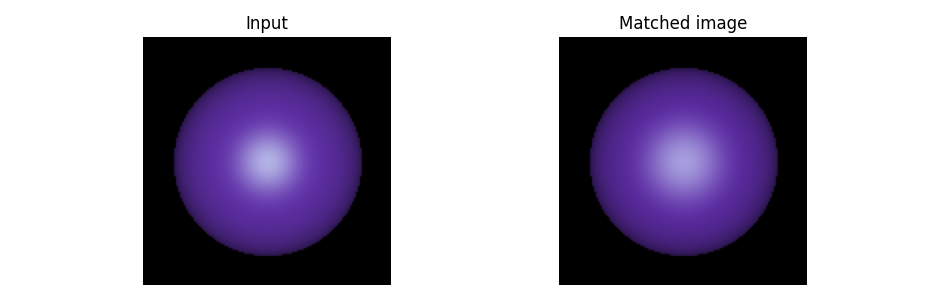

In [216]:
np.random.seed(38943)
random.seed(9343423)

def solve_phong_iterative(camera, sphere, light, image_to_match, positions, normals):
    height, width, _ = image_to_match.shape

    # Error for a given set of kd/ks/t estimates
    def estimate_SSD(kd, ks, t):
        brdf = gfx.PhongBRDF(kd, ks, t)
        estimated_image, _, _ = gfx.render(camera, sphere, light, brdf, width, height)
        return helpers.SSD_per_pixel(image_to_match, estimated_image)
    
    # Parameter settings
    t_estimate = 2
    threshold = 0.0001
    old_error = 0

    # first iteration
    kd_estimate, ks_estimate = solve_phong_kd_ks(image_to_match, positions, normals, t_estimate, camera.position, light)
    error = estimate_SSD(kd_estimate, ks_estimate, t_estimate)

    estimate_t = True
    i = 0
    print(kd_estimate, ks_estimate)

    while error >= threshold:
        if estimate_t:
            t_new = solve_phong_t(image_to_match, positions, normals, camera.position, light, kd_estimate, ks_estimate)
            if t_new > 0:
                t_estimate = t_new
            else:
                raise error()
        else: 
            kd_new, ks_new = solve_phong_kd_ks(image_to_match, positions, normals, t_estimate, camera.position, light)
            if (kd_new >= 0) & (kd_new <= 1) & (ks_new >= 0) & (ks_new <= 1):
                kd_estimate, ks_estimate = kd_new, ks_new
            else:
                raise error()
        new_error = estimate_SSD(kd_estimate, ks_estimate, t_estimate)
        
        if new_error == old_error:
            t_estimate = np.random.uniform(1,10)
            estimate_t = False
        
        old_error, error = error, new_error

        estimate_t = not estimate_t
        
        i +=1
        print(i)
        print(kd_estimate, ks_estimate, t_estimate)

        
    return kd_estimate, ks_estimate, t_estimate







# Suppress runtime warnings when iteration hits invalid kd/ks/t pair
import warnings
warnings.simplefilter('ignore', category=RuntimeWarning)
        
camera = gfx.Camera(gfx.Vec3(0, 0, -5), gfx.Vec3(0, 0, 0), gfx.Vec3(0, 1, 0), 45.0, 1.0)
sphere = gfx.Sphere(gfx.Vec3(0, 0, 0), 1.5)
light = gfx.DirectionalLight(gfx.Vec3(0, 0, 1), gfx.Vec3(1, 1, 1))

kd = gfx.Vec3(0.4, 0.2, 0.7)
ks = gfx.Vec3(0.3, 0.5, 0.2)
t = 6
width = height = 128
image_to_match, positions, normals = gfx.render(camera, sphere, light, gfx.PhongBRDF(kd, ks, t), width, height)

%time kd_estimate, ks_estimate, t_estimate = solve_phong_iterative(camera, sphere, light, image_to_match, positions, normals)

# Render the image with again at a higher resolution and with the estimated kd/ks/t values
print(f"Estimated values: kd={kd_estimate}, ks={ks_estimate}, t={t_estimate}")
width = height = 128
reference_image, _, _ = gfx.render(camera, sphere, light, gfx.PhongBRDF(kd, ks, t), width, height)
matched_image, _, _ = gfx.render(camera, sphere, light, gfx.PhongBRDF(kd_estimate, ks_estimate, t_estimate), width, height)

print(f"SSD per pixel: {helpers.SSD_per_pixel(reference_image, matched_image)}")
helpers.show_images({ "Input": reference_image, "Matched image": matched_image }, nrows=1, ncols=2)

### Tests of exercise 5
Your method should be able to estimate the Phong parameters with $0.0001$ of precision (as measured in the sum of squared differences per pixel).